In [ ]:
from trans import Dataset
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = Dataset('data/transcriptions/train.csv')
words_vocab = data.words_vocab
trans_vocab = data.trans_vocab

In [4]:
batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(32)

In [5]:
batch_words.size(), batch_trans_in.size(), batch_trans_out.size(), words_lens.size(), trans_lens.size()

(torch.Size([32, 12]),
 torch.Size([32, 13]),
 torch.Size([32, 13]),
 torch.Size([32]),
 torch.Size([32]))

In [46]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Encoder, self).__init__()
            
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.pad_idx = pad_idx
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.GRU_cell = nn.GRUCell(emb_size, hidden_size)
        
    def forward(self, batch_words):
        
        batch_size = batch_words.size(0)
        seq_len = batch_words.size(1)
        
        embedded = self.embedding(batch_words)
        
        hidden = torch.zeros(batch_size, self.hidden_size).to(batch_words.device)
        
        outputs = []
        for t in range(seq_len):    
            hidden = self.GRU_cell(embedded[:, t, :], hidden)
            outputs.append(hidden)
        outputs = torch.stack(outputs, dim = 1)  

        return outputs, hidden

class DotAttention(nn.Module):
    def __init__(self):
        super(DotAttention, self).__init__()
        
        
    def forward(self, outputs, hidden):
        '''
        Inputs:
            outputs: (batch_size, seq_len, hidden) - outputs of encoder
            hidden: (batch_size, hidden) - previous hidden state
            
        Outputs:
            weights: (batch_size, seq_len, 1)
            context: (batch, hidden)
        '''

        hidden =  hidden.unsqueeze(2)
        product = torch.matmul(outputs, hidden)

        weights = torch.softmax(product, dim = 2)

        context = (weights * outputs).sum(1)
        
        return weights, context
    
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        
        self.W = nn.Linear(2 * hidden_size, hidden_size)
        self.v_a = nn.Linear(hidden_size, 1)
        
        
    def forward(self, outputs, hidden):
        '''
        Inputs:
            outputs: (batch_size, seq_len, hidden) - outputs of encoder
            hidden: (batch_size, hidden) - previous hidden state
            
        Outputs:
            weights: (batch_size, seq_len, 1)
            context: (batch, hidden)
        '''

        hidden =  hidden.unsqueeze(1).repeat(1, outputs.size(1), 1)

        hidden_concat = torch.cat((outputs, hidden), 2)
        W = self.W(hidden_concat)
        W = F.tanh(W)
        wieghts = self.v_a(W)

        weights = torch.softmax(wieghts, dim = 2)

        context = (weights * outputs).sum(1)
        
        return weights, context

class GeneralAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GeneralAttention, self).__init__()
        
        self.W = nn.Linear(2 * hidden_size, hidden_size)
        self.v_a = nn.Linear(hidden_size, 1)
        
        
    def forward(self, outputs, hidden):
        '''
        Inputs:
            outputs: (batch_size, seq_len, hidden) - outputs of encoder
            hidden: (batch_size, hidden) - previous hidden state
            
        Outputs:
            weights: (batch_size, seq_len, 1)
            context: (batch, hidden)
        '''

        hidden =  hidden.unsqueeze(1).repeat(1, outputs.size(1), 1)

        hidden_concat = torch.cat((outputs, hidden), 2)
        W = self.W(hidden_concat)
        W = F.tanh(W)
        wieghts = self.v_a(W)

        weights = torch.softmax(wieghts, dim = 2)

        context = (weights * outputs).sum(1)
        
        return weights, context
        
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx, dot = False):
        super(Decoder, self).__init__()
    
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        if dot:
            self.attention = DotAttention()
        else: 
            self.attention = BahdanauAttention(hidden_size)
            
        self.GRU_cell = nn.GRUCell(emb_size + hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, outputs, hidden, target):
 
        _, context = self.attention(outputs, hidden)       
        
        embedded = self.embedding(target)
        
        x_t = torch.cat((embedded, context), dim = 1)
        
        hidden = self.GRU_cell(x_t, hidden)
        
        out = self.linear(hidden)
        
        
        return out, hidden

In [47]:
encoder = Encoder(len(words_vocab), 32, 64, pad_idx=words_vocab.pad_idx)
decoder = Decoder(len(trans_vocab), 32, 64, pad_idx=words_vocab.pad_idx)

criterion = nn.CrossEntropyLoss()

encoder_optimizer = optim.Adam(encoder.parameters())
decoder_optimizer = optim.Adam(decoder.parameters())

In [48]:
num_epochs = 5
batch_size = 32
losses = []

In [49]:
class Model(nn.Module):
    def __init__(self, dataset, encoder, decoder):
        super(Model, self).__init__()
        self.dataset = dataset
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_words, batch_trans_in):
        outputs, hidden = self.encoder(batch_words)

        logits = []
        for  t in range(batch_trans_in.size(1)):
            logit, hidden = self.decoder(outputs, hidden,  batch_trans_in[:, t])
            logits.append(logit)


        logits = torch.stack(logits, 1)
        logits = logits.view(-1, len(self.dataset.trans_vocab))
        
        
        return logits
    

In [50]:
class Trainer:
    def __init__(self, dataset, model, encoder_optimizer, decoder_optimizer, criterion, batch_size):
        
        
        self.dataset = dataset
        self.train_losses = []
        self.val_losses = []
        self.batch_size = batch_size
        
        self.model = model
        self.encoder_optimizer = encoder_optimizer
        self.decoder_optimizer = decoder_optimizer
        self.criterion = criterion
        
               
    def train(self, n_epochs):
        
        for epoch in range(n_epochs):

            for batch_idx in range(len(self.dataset)//self.batch_size):

                batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = self.dataset.get_batch(32)
                
                logits = self.model(batch_words, batch_trans_in)
                
                batch_trans_out = batch_trans_out.view(-1)  
                mask = batch_trans_out != self.dataset.trans_vocab.pad_idx

                loss = self.criterion(logits[mask], batch_trans_out[mask])

                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()

                loss.backward()

                self.encoder_optimizer.step()
                self.decoder_optimizer.step()

                self.train_losses.append(loss.item())
                
                if batch_idx % 200 == 0:
                    val_loss = self.eval_()
                    self.val_losses.append(val_loss.item())
                    self.plot(epoch, batch_idx, self.train_losses, self.val_losses)
            
            
        
    def eval_(self):
        
        val_words, val_trans_in, val_trans_out, val_words_lens, val_trans_lens = self.dataset.get_batch(32, val = True)
        
        logits = self.model(val_words, val_trans_in)
        val_trans_out = val_trans_out.view(-1)                

        mask = val_trans_out != trans_vocab.pad_idx

        loss = self.criterion(logits[mask], val_trans_out[mask])

        return loss
        
    def plot(self, epoch, batch_idx, train_losses, val_losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, train_losses[-1]))
        plt.plot(train_losses)
        plt.subplot(132)
        plt.title('epoch %s. | loss: %s' % (epoch, val_losses[-1]))
        plt.plot(val_losses)
        plt.show()  

In [51]:
model = Model(data, encoder, decoder)
trainer = Trainer(data, model, encoder_optimizer, decoder_optimizer, criterion, batch_size = 32)

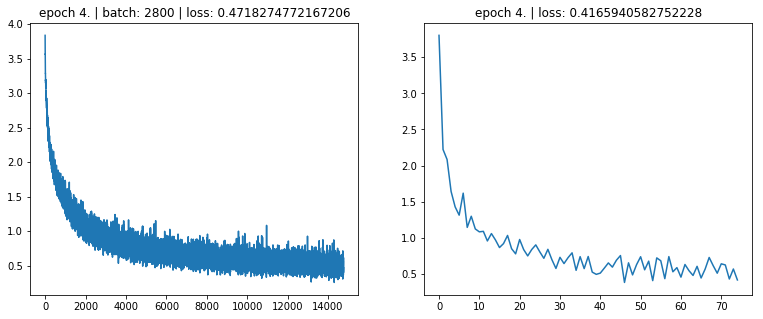

In [52]:
trainer.train(5)

In [57]:
min(trainer.val_losses)

0.38209766149520874